# MMMI Oversight Script


**TODO**: Consolidate initial setup to use same scripts as in interim. I.e., by having all agents 'attentive' to start.

**TODO**: Option for rolling macro updates

**TODO**: track and display agent histories of consumption and earnings as well as dividend payouts.

**TODO**: Test for expected behavior with maximum attention rating (1)

**TODO**: `requirements.txt`

**TODO**: Begin automated tests

**TODO**: How do deal with varying 'AdjustPrbs' in quarterly and daily solution steps.

**TODO**: What are the macro population statistics, given our concept of macro agents including institutional investors, etc.

**TODO**: Fix steady state computation

**TODO**: Reduce NL logging/warning in the notebook.

In [1]:
import HARK.ConsumptionSaving.ConsPortfolioModel as cpm
from HARK.Calibration.Income.IncomeTools import (
     sabelhaus_song_var_profile,
)
import hark_portfolio_agents as hpa

import logging
import math
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

## Portfolio Consumption Model

Variable | Equation | Operation | Stage | Utility
-- | -- | -- | -- | --
\Risky | ~Dist | Shock | c | --
\TranShk | ~Dist | Shock | c | --
\PermShk | ~Dist | Shock | c | --
\Rport | \Rport = \PortShare * \Risky + (1 - \PortShare) * R | Update | c | --
b | b_{t} = a_{t-1} \RPort | Update | c | --
p | p_{t}=p_{t-1}\PermShk_{t} | Update | c | --
y | y_{t} = p_{t}\TranShk_{t} | Update | c | --
m | m_{t} = b_{t} + y_{t} | Update | c | --
c | c | Control | c | U(c)
a | a_{t} = m_{t} - c_{t} | Update | portshare | --
\PortShare | \PortShare | Control | portshare | 0


## Initialize the Simulation

### Initialize market information

Some initial values for the simulation.

$RAP_0$ is the starting risky asset price. This is adjust after every trading day.

HARK uses numerical values for wealth. This variable converts "HARK money" to dollars.

In [2]:
dollars_per_hark_money_unit = 1500

Expected rate of return and standard deviation of the market price process will be updated over time.

These are the starting values, derived from the S&P 500.

$\bar{r}_0 = 0.000628$

$sr_0 = 0.011988$

In [3]:
# sp500_ror = 0.000628 -> on financial model
# sp500_std = 0.011988

Quarterly dividend rate and standard deviation.

In [4]:
# dividend_ror -> on financial model; on MarketPNL
# dividend_std -> on financial model; on MarketPNL

Calendar variables. Will ultimately set to be realistic; for now set low for testing.

In [5]:
# Now set in Financial Model
days_per_quarter = 60 # Number of days in a quarter / An empirical value based on trading calendars.

# Simulation parameters
quarters_per_simulation = 6 # Number of quarters to run total

# Number of market runs to do per quarter
# Valid values: 1, 2, 3, 4, 5, 6, 10, 12, 15, 20, 30, 60...
runs_per_quarter = 2 

# For John's prefered condition: days per quarter = runs per quarter
# Best if an integer.
days_per_run = days_per_quarter / runs_per_quarter

An attention rate: the chance on any run that an agent will pay attention to the market and trade.

Later, this can be a more realistic function of agent circumstances.

In [6]:
attention_rate = 1 / runs_per_quarter ## upping this to make more agents engaged in trade

A times we will need to combine the quarterly rates from the price process (capital gains) and the dividends.


### Data stores

For prices, rates or return, and standard deviations over time.

In [7]:
history = {}

history['buy_sell'] = []
history['owned_shares'] = []
history['total_assets'] = []

### Initialize agents to start

This is to set up the agent parameters and quantities used in the simulation.

`CRRA` refers to the `\rho` parameter in the constant relative risk aversion utility function used by the agents. Utility is over units of resources consumed.

`aNrmInitStd` is normalized initial market assets, standard deviation. The agents' starting wealth is drawn from a lognormal distribution with this standard deviation.

`pLvlInitMean` and `pLvlInitStd` are the mean and standard deviation of the initial level of permanent income of the agents.

In [8]:
## List of tuples: 
##  ( parameters, (i.e. coefficient of relative risk aversion CRRA)
##    number of agents represented,
##    ( initial risky percent, $$$ in risky asset, $$$ in riskless asset)
agent_classes = [
    {
        'CRRA': 2, #2, The level in cstwMPC paper 1.0
        'AgentCount' : 10
    }] * 20 + \
    [{
        'CRRA': 5, #3, 
        'AgentCount' : 10
    }] * 20 + \
    [{
        'CRRA': 10, #10, 
        'AgentCount' : 10
    }] * 20

# Get empirical data from Sabelhaus and Song
ssvp = sabelhaus_song_var_profile()

# Assume all the agents are 40 for now.
# We will need to make more coherent assumptions about the timing and age of the population later.
# Scaling from annual to quarterly
idx_40 = ssvp['Age'].index(40)

### parameters shared by all agents
agent_parameters = {
    'aNrmInitStd' : 0.0,
    'LivPrb' : [0.98 ** 0.25],
    'PermGroFac': [1.01 ** 0.25],
    'pLvlInitMean' : 1.0, # initial distribution of permanent income
    'pLvlInitStd' : 0.0,
    'Rfree' : 1.0,
    'TranShkStd' : [ssvp['TranShkStd'][idx_40] / 2],  # Adjust non-multiplicative shock to quarterly
    'PermShkStd' : [ssvp['PermShkStd'][idx_40] ** 0.25]
}

## Get agent risky allocations

Use this stock price to determine the initial number of shares of the risky asset held by each
agent:
 - $RAS_{i0} = (HEC_{i0}.RAW)/ RAP_0$
 
 where RAW is Risky Asset Wealth, amount of resources allocated to the risky asset.
 
 RAS is Risky Asset Shares, number of shares the agent has.

In [9]:
def compute_share_demand(agent, fm):
    """
    Computes the number of shares an agent _wants_ to own.
    
    This involves:
      - Computing a solution function based on their
        expectations and personal properties
      - Using the solution and the agent's current normalized
        assets to compute a share number
    """
    agent.assign_parameters(AdjustPrb = 1.0)
    agent.solve()
    asset_normalized = agent.state_now['aNrm']

    # ShareFunc takes normalized market assets as argument
    risky_share = agent.solution[0].ShareFuncAdj(
        asset_normalized
    )
    
    # denormalize the risky share. See https://github.com/econ-ark/HARK/issues/986
    risky_asset_wealth = risky_share \
                        * asset_normalized \
                        * agent.state_now['pLvl'] \
                        * dollars_per_hark_money_unit 
        
    shares = risky_asset_wealth / fm.rap()
    
    if (np.isnan(shares)).any():
        print("ERROR: Agent has nan shares")
    
    return shares

## Prepare the main loop

Functions to automate aspects of the main loop.
(Will move this to module code once finalized).



### Activating agents

"At the beginning of each trading day $t + 1$, select a random group of HARK agents with replacement."

**TODO**: HARK AgentType classes represent multiple agents (as many as `AgentCount`). It is difficult to have the agents within the same AgentType act 'separately', though these agents will have _ex ante_ and _ex post_ heterogeneity of some variables. For the purpose of MMMI, we may need to scaffold the agent model to make it easier to have multiple independently acting agents.

"**First**, determine the expected return and standard deviation of the risky asset to be used for decision period $t + 1$."

See `calculate_risky_expectations()`.

"**Second**, using [these expectations] calculate the total number of shares of the risky asset that the selected agents want to buy and sell."

In [10]:
class Broker():
    
    buy_limit = 0
    sell_limit = 0
    
    buy_sell_history = []
    
    market = None
    
    def __init__(self, market):
        self.market = market
        
    def transact(self, delta_shares):
        """
        Input: an array of share deltas. positive for buy, negative for sell.
        """
        self.buy_limit += delta_shares[delta_shares > 0].sum()
        self.sell_limit += -delta_shares[delta_shares < 0].sum()
        
    def trade(self, seed = None):
        """
        Broker executes the trade on the financial market and then updates
        their record of the current asset price.
        
        Input: (optional) random seed for the simulation
        Output: Rate of return of the asset value that day.
        """
        
        # use integral shares here.
        buy_sell = (int(self.buy_limit), int(self.sell_limit))
        self.buy_sell_history.append(buy_sell)
        print("Buy/Sell Limit: " + str(buy_sell))
        
        self.market.run_market(buy_sell = buy_sell, seed = seed)
        
        # clear the local limits
        self.buy_limit = 0
        self.sell_limit = 0
        
        return buy_sell, self.market.daily_rate_of_return()

In [11]:
def attend(agent, fm):
    """
    Cause the agent to attend to the financial model.
    
    This will update their expectations of the risky asset.
    They will then adjust their owned risky asset shares to meet their
    target.
    
    Return the delta of risky asset shares ordered through the brokers.
        
    NOTE: This MUTATES the agents with their new target share amounts.
    """
    # Note: this mutates the underlying agent
    agent.assign_parameters(**fm.risky_expectations())
            
    d_shares = compute_share_demand(agent, fm)
            
    delta_shares = d_shares - agent.shares
            
    # NOTE: This mutates the agent
    agent.shares = d_shares
    
    return delta_shares

"**Third**, using [total buy and sell shares] as input to the Buy Broker and Sell Broker, run a day of NetLogo trading and determine the end of day price of the risky asset."

See `hpa.run_market`.

"**Fourth**, use the final price to calculate the amount of wealth each (all) HARK agent has allocated to the risky asset."

In [12]:
def update_agent_wealth_capital_gains(agents, old_share_price, ror):
    """
    For all agents,
    given the old share price
    and a rate of return
    
    update the agent's wealth level to adjust
    for the most recent round of capital gains.
    """

    new_share_price = old_share_price * (1 + ror)

    for agent in agents:
        old_raw = agent.shares * old_share_price
        new_raw = agent.shares * new_share_price
    
        delta_aNrm = (new_raw - old_raw) / \
            (dollars_per_hark_money_unit * agent.state_now['pLvl'])
    
        # update normalized market assets
        # if agent.state_now['aNrm'] < delta_aNrm:
        #     breakpoint()
        
        agent.state_now['aNrm'] = agent.state_now['aNrm'] + delta_aNrm
        
        if (agent.state_now['aNrm'] < 0).any():
            print(f"ERROR: Agent with CRRA {agent.parameters['CRRA']} has negative aNrm after capital gains update.")
            print("Setting normalize assets and shares to 0.")
            agent.state_now['aNrm'][(agent.state_now['aNrm'] < 0)] = 0.0
            ## TODO: This change in shares needs to be registered with the Broker.
            agent.shares[(agent.state_now['aNrm'] == 0)] = 0

        # update non-normalized market assets
        agent.state_now['aLvl'] = agent.state_now['aNrm']  * agent.state_now['pLvl']

"Repeat each trading day until the end of the quarter. Then update the economic conditions for each HARK agent (e.g., permanent income level), and repeat [daily loop]."

In [13]:
def macro_update(agent, fm, broker):
    """
    Input: an agent, a FinancialModel, and a Broker
    
    Simulates one "macro" period for the agent (quarterly by assumption).
    For the purposes of the simulation, award the agent dividend income
    but not capital gains on the risky asset.
    """
    
    #agent.assign_parameters(AdjustPrb = 0.0)
    agent.solve()
        
    ## For risky asset gains in the simulated quarter,
    ## use only the dividend.
    true_risky_expectations = {
        "RiskyAvg" : agent.parameters['RiskyAvg'],
        "RiskyStd" : agent.parameters['RiskyStd']   
    }
        
    dividend_risky_params = {
        "RiskyAvg" : 1 + fm.dividend_ror,
        "RiskyStd" : fm.dividend_std
    }
        
    agent.assign_parameters(**dividend_risky_params)
        
    agent.simulate(sim_periods=1)
        
    ## put back the expectations that include capital gains now
    agent.assign_parameters(**true_risky_expectations)
    
    # Selling off shares if necessary to
    # finance this period's consumption
    asset_level_in_shares = agent.state_now['aLvl'] \
        * dollars_per_hark_money_unit / fm.rap()

    delta = asset_level_in_shares - agent.shares
    delta[delta > 0] = 0

    agent.shares = agent.shares + delta
    broker.transact(delta)

Accounting functions.

In [14]:
## Clean this up!

def total_asset_levels(agents):
    tal = sum(
                [agent.state_now['aLvl'].sum()
                 for agent
                 in agents]
            ) * dollars_per_hark_money_unit
    print("Total Asset Levels: " + str(tal))
    return tal


def owned_shares(agents):
    os = sum([sum(agent.shares) for agent in agents])
    print("Owned Shares: " + str(os))
    return os

def track(agents, history):
    history['owned_shares'].append(owned_shares(agents))
    history['total_assets'].append(total_asset_levels(agents))
    

## Run the main loop



In [15]:
import itertools

seeds = itertools.cycle([2,3,6,0,1,4,5])

# Initialize the financial model
fm = hpa.FinanceModel()

fm.calculate_risky_expectations()
agent_parameters.update(fm.risky_expectations())

# Initialize the population model
agents = hpa.create_distributed_agents(agent_classes, agent_parameters)
hpa.init_simulations(agents)

# Create the Market wrapper
market = hpa.MarketPNL()
broker = Broker(market)

# Initialize share ownership for agents
for agent in agents:
    agent.shares = compute_share_demand(agent, fm)

track(agents, history)

# Main loop
for quarter in range(quarters_per_simulation):
    print(f"Q-{quarter}")
    
    for agent in agents:
        macro_update(agent, fm, broker)

    day = 0

    for run in range(runs_per_quarter):
        print(f"Q-{quarter}:R-{run}")
        
        # Set to a number for a fixed seed, or None to rotate
        seed = next(seeds)

        for agent in agents:
            if random.random() < attention_rate:
                broker.transact(attend(agent,fm))

        buy_sell, ror = broker.trade(seed)
        print("ror: " + str(ror))
        
        new_run = True
        
        for new_day in range(int(days_per_run)):
            if new_run:
                new_run = False
            else:
                # sloppy
                # problem is that this should really be nan, nan
                # putting 0,0 here is a stopgap to make plotting code simpler
                broker.buy_sell_history.append((0,0))
            
            day = day + 1
            print(f"Q-{quarter}:D-{day}")
        
            update_agent_wealth_capital_gains(agents, fm.rap(), ror)
        
            track(agents, history)

            # combine these steps?
            risky_asset_price = fm.add_ror(ror)
            fm.calculate_risky_expectations()

            print(f"Price end of day {day}: {risky_asset_price}")
            print("") # line break for presentation

D_t: 0
S_t / w_0  : 1.0
daily expectations: 0.000628,0.011988
config_file: ../PNL/macroliquidity.ini
config_local_file: ../PNL/macroliquidity_local.ini
Owned Shares: 6359.379704426231
Total Asset Levels: 635937.9704426232
Q-0
Q-0:R-0


Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (1313, 0)


NL model: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/nl/LiquidityModel_MP_PNL_wBuyBroker_and_SellBroker_thin_out.nlogo
NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL1313SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks:

Elapsed (sys clock), run 2:  50.02145145899999
ror: 0.02799105073529412
Q-0:D-1
Owned Shares: 7673.031301981262
Total Asset Levels: 949072.9825087481
D_t: 1.0797751623277096
S_t / w_0  : 0.9623506263980885
daily expectations: 0.0016582017200211462,0.012822178458865649
Price end of day 1: 102.7991050735294

Q-0:D-2
Owned Shares: 7673.031301981262
Total Asset Levels: 971151.7845302697
D_t: 2.2456895635075416
S_t / w_0  : 0.9261187281287935
daily expectations: 0.002649616990599882,0.013436524616154057
Price end of day 2: 105.67656003918539

Q-0:D-3
Owned Shares: 7673.031301981262
Total Asset Levels: 993848.595419346
D_t: 3.504614975301709
S_t / w_0  : 0.8912509381337456
daily expectations: 0.003603706097261959,0.01388384963273402
Price end of day 3: 108.63455799277358

Q-0:D-4
Owned Shares: 7673.031301981262
Total Asset Levels: 1017180.7138935511
D_t: 4.863971366180234
S_t / w_0  : 0.8576958985908941
daily expectations: 0.004521874346697804,0.014200096279776434
Price end of day 4: 111.675

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (335, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL335SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 3:  28.643409391999995
ror: 0.01476899191176471
Q-0:D-31
Owned Shares: 8008.296386622374
Total Asset Levels: 1943862.667604491
D_t: 132.6148207133876
S_t / w_0  : 0.30432198871077215
daily expectations: 0.01891492994876399,0.00986658455126124
Price end of day 31: 232.29892751202306

Q-0:D-32
Owned Shares: 8008.296386622374
Total Asset Levels: 1971337.6988740806
D_t: 144.2739647251859
S_t / w_0  : 0.2928644564625237
daily expectations: 0.018522048970975324,0.009857623319598123
Price end of day 32: 235.72974849355973

Q-0:D-33
Owned Shares: 8008.296386622374
Total Asset Levels: 1999218.5086582638
D_t: 156.86321884312756
S_t / w_0  : 0.2818382931264454
daily expectations: 0.01815760751621046,0.00981197034779731
Price end of day 33: 239.2112392424234

Q-0:D-34
Owned Shares: 8008.296386622374
Total Asset Levels: 2027511.0898966447
D_t: 170.4567827519128
S_t / w_0  : 0.27122725793320285
daily expectations: 0.01781985558973572,0.009736248718354868
Price end of day 34:

Sim ID (SEED): 6
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (238, 2474)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD6BL238SL2474.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks:

Elapsed (sys clock), run 6:  33.145944152
ror: -0.029304537500000005
Q-1:D-1
Owned Shares: 5772.127657611175
Total Asset Levels: 2091929.0927700482
D_t: 1447.9652762239862
S_t / w_0  : 0.09623506263980887
daily expectations: 0.011443097235681267,0.012448401113318694
Price end of day 1: 344.96787964934583

Q-1:D-2
Owned Shares: 5772.127657611175
Total Asset Levels: 2033577.937580257
D_t: 1564.5567163419694
S_t / w_0  : 0.09261187281287935
daily expectations: 0.008653271305923593,0.015931274684265327
Price end of day 2: 334.85875548386605

Q-1:D-3
Owned Shares: 5772.127657611175
Total Asset Levels: 1976936.736005894
D_t: 1690.449257521386
S_t / w_0  : 0.08912509381337458
daily expectations: 0.006053661731495674,0.018175389115997018
Price end of day 3: 325.04587452658575

Q-1:D-4
Owned Shares: 5772.127657611175
Total Asset Levels: 1921955.378647109
D_t: 1826.3848966092385
S_t / w_0  : 0.08576958985908942
daily expectations: 0.003631574074793346,0.019704468318038185
Price end of day 4: 315

Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (368, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL368SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 0:  26.478450715999998
ror: 0.03680575661764706
Q-1:D-31
Owned Shares: 6140.169228266336
Total Asset Levels: 974105.7123173212
D_t: 14601.46983132997
S_t / w_0  : 0.030432198871077218
daily expectations: -0.0196250377836713,0.02055504626242969
Price end of day 31: 150.9673547545767

Q-1:D-32
Owned Shares: 6140.169228266336
Total Asset Levels: 1008223.364406846
D_t: 15767.384232509801
S_t / w_0  : 0.029286445646252372
daily expectations: -0.0155527892749428,0.02466215174078025
Price end of day 32: 156.5238224708836

Q-1:D-33
Owned Shares: 6140.169228266336
Total Asset Levels: 1043596.7424955403
D_t: 17026.30964430397
S_t / w_0  : 0.028183829312644543
daily expectations: -0.011773809927529738,0.027382274967529593
Price end of day 33: 162.28480018561072

Q-1:D-34
Owned Shares: 6140.169228266336
Total Asset Levels: 1080272.0645289125
D_t: 18385.666035182494
S_t / w_0  : 0.02712272579332028
daily expectations: -0.00826713616190521,0.029235874947094433
Price end of d

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (80, 2702)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL80SL2702.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 1:  27.218115094999973
ror: -0.038119243382352945
Q-2:D-1
Owned Shares: 3517.714459419231
Total Asset Levels: 1493741.9780329762
D_t: 146136.51538238977
S_t / w_0  : 0.00962350626398089
daily expectations: 0.025327789852839656,0.025535324518961136
Price end of day 1: 414.2179141647736

Q-2:D-2
Owned Shares: 3517.714459419231
Total Asset Levels: 1438198.4153109898
D_t: 157795.6593941881
S_t / w_0  : 0.009261187281287936
daily expectations: 0.020674722993728394,0.029649685530992228
Price end of day 2: 398.428240681396

Q-2:D-3
Owned Shares: 3517.714459419231
Total Asset Levels: 1384772.1311747276
D_t: 170384.91351212974
S_t / w_0  : 0.008912509381337455
daily expectations: 0.01636265464330904,0.032409821165014153
Price end of day 3: 383.24045760445915

Q-2:D-4
Owned Shares: 3517.714459419231
Total Asset Levels: 1333382.4165664702
D_t: 183978.477420915
S_t / w_0  : 0.00857695898590894
daily expectations: 0.012366655256494413,0.034286590593285954
Price end of day 4

Sim ID (SEED): 4
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (128, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD4BL128SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 4:  29.275812848999976
ror: -0.007267772794117647
Q-2:D-31
Owned Shares: 3646.0849459152073
Total Asset Levels: 505154.3594522235
D_t: 1461486.9708929877
S_t / w_0  : 0.003043219887107724
daily expectations: -0.029380103058439147,0.021582982318189194
Price end of day 31: 133.22227680260102

Q-2:D-32
Owned Shares: 3646.0849459152073
Total Asset Levels: 501624.11340001645
D_t: 1578078.4110109708
S_t / w_0  : 0.002928644564625238
daily expectations: -0.027747887411500322,0.021566375595019192
Price end of day 32: 132.25404756368468

Q-2:D-33
Owned Shares: 3646.0849459152073
Total Asset Levels: 498119.52437402325
D_t: 1703970.9521903875
S_t / w_0  : 0.002818382931264455
daily expectations: -0.026236040483676434,0.021439666813703174
Price end of day 33: 131.2928551948894

Q-2:D-34
Owned Shares: 3646.0849459152073
Total Asset Levels: 494640.4059048077
D_t: 1839906.59127824
S_t / w_0  : 0.002712272579332029
daily expectations: -0.024835695627270876,0.021225145145952518

Sim ID (SEED): 5
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (441, 26)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD5BL441SL26.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 5:  25.557960766000008
ror: -0.0028604198529411764
Q-3:D-1
Owned Shares: 4060.6527778994136
Total Asset Levels: 487074.56379648054
D_t: 14614991.525998965
S_t / w_0  : 0.0009623506263980887
daily expectations: -0.009153104253465374,0.00968884846944955
Price end of day 1: 107.51382337817363

Q-3:D-2
Owned Shares: 4060.6527778994136
Total Asset Levels: 485825.7722647247
D_t: 15780905.927178796
S_t / w_0  : 0.0009261187281287935
daily expectations: -0.008688282161426203,0.009468971404852079
Price end of day 2: 107.20628870331709

Q-3:D-3
Owned Shares: 4060.6527778994136
Total Asset Levels: 484580.55280105706
D_t: 17039831.338972963
S_t / w_0  : 0.0008912509381337461
daily expectations: -0.008257783356032911,0.009239780982884057
Price end of day 3: 106.89963370674998

Q-3:D-4
Owned Shares: 4060.6527778994136
Total Asset Levels: 483338.8951878656
D_t: 18399187.729851488
S_t / w_0  : 0.0008576958985908946
daily expectations: -0.007859074309618321,0.009003928913311495

Sim ID (SEED): 2
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (249, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD2BL249SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 2:  28.537663796000004
ror: 0.010361638970588236
Q-3:D-31
Owned Shares: 4309.778063145579
Total Asset Levels: 456691.6725690716
D_t: 146150037.07705876
S_t / w_0  : 0.0003043219887107723
daily expectations: -0.002512811237613857,0.005117221572737287
Price end of day 31: 99.96865756718556

Q-3:D-32
Owned Shares: 4309.778063145579
Total Asset Levels: 461155.90936333995
D_t: 157809181.08885705
S_t / w_0  : 0.000292864456462524
daily expectations: -0.001561874346107516,0.005965962980799655
Price end of day 32: 101.00449670527111

Q-3:D-33
Owned Shares: 4309.778063145579
Total Asset Levels: 465666.4029675499
D_t: 170398435.20679873
S_t / w_0  : 0.00028183829312644545
daily expectations: -0.000681174995064865,0.006533831783003904
Price end of day 33: 102.0510688345371

Q-3:D-34
Owned Shares: 4309.778063145579
Total Asset Levels: 470223.63267806655
D_t: 183991999.11558396
S_t / w_0  : 0.0002712272579332031
daily expectations: 0.00013447428812426163,0.00691959628937892

Sim ID (SEED): 3
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (15, 897)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD3BL15SL897.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 5

Elapsed (sys clock), run 3:  24.32166116799999
ror: -0.029304537500000005
Q-4:D-1
Owned Shares: 3427.6979591883146
Total Asset Levels: 450198.6810700892
D_t: 1461500492.5876563
S_t / w_0  : 9.623506263980884e-05
daily expectations: 0.00614298006560897,0.010846554005511195
Price end of day 1: 130.85052604889972

Q-4:D-2
Owned Shares: 3427.6979591883146
Total Asset Levels: 437055.12475224317
D_t: 1578091932.7056394
S_t / w_0  : 9.261187281287941e-05
daily expectations: 0.0035242956749338937,0.013961603657994974
Price end of day 2: 127.01601190140501

Q-4:D-3
Owned Shares: 3427.6979591883146
Total Asset Levels: 424296.7342733971
D_t: 1703984473.8850563
S_t / w_0  : 8.912509381337452e-05
daily expectations: 0.0010990661561989027,0.015945601448164485
Price end of day 3: 123.29386641753983

Q-4:D-4
Owned Shares: 3427.6979591883146
Total Asset Levels: 411912.2225267771
D_t: 1839920112.9729087
S_t / w_0  : 8.576958985908944e-05
daily expectations: -0.0011469996284013233,0.017283565299704932
Pr

Owned Shares: 3446.9453979399386
Total Asset Levels: 226764.01901783195
D_t: 125352298975.47629
S_t / w_0  : 1.03912230383517e-05
daily expectations: 0.002560399659488032,0.010468792040502967
Price end of day 59: 65.60721077107044

Q-4:D-60
Owned Shares: 3446.9453979399386
Total Asset Levels: 228110.54789546755
D_t: 135352298975.47629
S_t / w_0  : 9.999999999999997e-06
daily expectations: 0.0028111410661339166,0.010113691043327315
Price end of day 60: 65.9978548695933

Q-5
Q-5:R-0


Sim ID (SEED): 0
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (368, 374)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD0BL368SL374.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 

Elapsed (sys clock), run 0:  24.64909266799998
ror: -0.02048983161764706
Q-5:D-1
Owned Shares: 3440.631138515736
Total Asset Levels: 245005.63479061986
D_t: 146150050598.75336
S_t / w_0  : 9.623506263980891e-06
daily expectations: 0.0010896513441936103,0.01148384268587216
Price end of day 1: 64.64556993618942

Q-5:D-2
Owned Shares: 3440.631138515736
Total Asset Levels: 240448.2544598587
D_t: 157809194610.55164
S_t / w_0  : 9.261187281287947e-06
daily expectations: -0.0005046536991602384,0.012409586290271602
Price end of day 2: 63.32099309337007

Q-5:D-3
Owned Shares: 3440.631138515736
Total Asset Levels: 235984.2540846926
D_t: 170398448728.4933
S_t / w_0  : 8.912509381337458e-06
daily expectations: -0.001981170522817958,0.013036436706599859
Price end of day 3: 62.02355660702472

Q-5:D-4
Owned Shares: 3440.631138515736
Total Asset Levels: 231611.72032555458
D_t: 183992012637.2785
S_t / w_0  : 8.57695898590895e-06
daily expectations: -0.0033486013741928547,0.013447384201559895
Price end 

Sim ID (SEED): 1
-------------------------- CONFIG ----------------------------
Current working directory: /home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/HARK
[DEFAULT]
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
loginfo=20
lognotset=0
logwarn=30
parallelcores=0
pythondir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/py
[pnl]
bkrbuy_limit=10
bkrsel_limit=10
csvflushinterval=100
liqbkr_ordersizemultiplier=10
lmallorderpfx=LMallorders_
lmallordersfx=csv
lminventorypfx=LMinventory_
lminventorysfx=csv
lmorderbookpfx=LMorderbook_
lmorderbooksfx=csv
lmtickssimruns=720
lmtickswarmups=5000
lmtraderctpfx=LMtradercts_
lmtraderctsfx=csv
lmtransactpfx=LMtransactions_
lmtransactsfx=csv
logdebug=10
logdir=/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs
logerror=40
logfatal=50
logfilepfx=LM_
logfilesfx=log
logformat=%(asctime)s::[%(levelname)s]::%(module)s::%(lineno)d — %(message)s
loginfo=20
loglevel=INFO
lognots

Buy/Sell Limit: (348, 0)


NL model loaded
NL model -- setup begin
NL model -- setup end
NL model -- warmups begin: 5000
NL model -- warmups end
Opening transaction log:/home/sb/projects/econ-ark/markets/HARK_ABM_INTRO/PNL/out/logs/LMtransactions_SD1BL348SL0.csv
NL model -- simruns begin: 720
 -- Ticks: 5672
 -- Ticks: 5673
 -- Ticks: 5674
 -- Ticks: 5675
 -- Ticks: 5676
 -- Ticks: 5677
 -- Ticks: 5678
 -- Ticks: 5679
 -- Ticks: 5680
 -- Ticks: 5681
 -- Ticks: 5682
 -- Ticks: 5683
 -- Ticks: 5684
 -- Ticks: 5685
 -- Ticks: 5686
 -- Ticks: 5687
 -- Ticks: 5688
 -- Ticks: 5689
 -- Ticks: 5690
 -- Ticks: 5691
 -- Ticks: 5692
 -- Ticks: 5693
 -- Ticks: 5694
 -- Ticks: 5695
 -- Ticks: 5696
 -- Ticks: 5697
 -- Ticks: 5698
 -- Ticks: 5699
 -- Ticks: 5700
 -- Ticks: 5701
 -- Ticks: 5702
 -- Ticks: 5703
 -- Ticks: 5704
 -- Ticks: 5705
 -- Ticks: 5706
 -- Ticks: 5707
 -- Ticks: 5708
 -- Ticks: 5709
 -- Ticks: 5710
 -- Ticks: 5711
 -- Ticks: 5712
 -- Ticks: 5713
 -- Ticks: 5714
 -- Ticks: 5715
 -- Ticks: 5716
 -- Ticks: 57

Elapsed (sys clock), run 1:  23.942603738999992
ror: 0.019176344852941174
Q-5:D-31
Owned Shares: 3789.3102319535196
Total Asset Levels: 147182.64365705007
D_t: 1461500506109.3506
S_t / w_0  : 3.0432198871077216e-06
daily expectations: -0.015401246528755932,0.012251826923678584
Price end of day 31: 36.144949233523874

Q-5:D-32
Owned Shares: 3789.3102319535196
Total Asset Levels: 149809.12072192135
D_t: 1578091946227.3335
S_t / w_0  : 2.9286445646252387e-06
daily expectations: -0.012846615813427739,0.014860154029284553
Price end of day 32: 36.83807724471798

Q-5:D-33
Owned Shares: 3789.3102319535196
Total Asset Levels: 152485.96401673707
D_t: 1703984487406.7498
S_t / w_0  : 2.818382931264458e-06
daily expectations: -0.010480723988507702,0.0165733213121969
Price end of day 33: 37.544496917681975

Q-5:D-34
Owned Shares: 3789.3102319535196
Total Asset Levels: 155214.13938169144
D_t: 1839920126494.6023
S_t / w_0  : 2.7122725793320293e-06
daily expectations: -0.008289626831010876,0.0177359065

In [16]:
data = pd.DataFrame.from_dict({
    't' : range(len(fm.prices)),
    'prices' : fm.prices,
    'buy' : [None] + [bs[0] for bs in broker.buy_sell_history],
    'sell' : [None]  + [bs[1] for bs in broker.buy_sell_history],
    'owned' : history['owned_shares'],
    'total_assets' : history['total_assets'],
    'ror' : [None] + fm.ror_list,
    'expected_ror' : fm.expected_ror_list,
    'expected_std' : fm.expected_std_list,
})


data

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
0,0,100.000000,NaN,NaN,6359.379704,6.359380e+05,NaN,0.000628,0.011988
1,1,102.799105,1313.0,0.0,7673.031302,9.490730e+05,0.027991,0.001658,0.012822
2,2,105.676560,0.0,0.0,7673.031302,9.711518e+05,0.027991,0.002650,0.013437
3,3,108.634558,0.0,0.0,7673.031302,9.938486e+05,0.027991,0.003604,0.013884
4,4,111.675353,0.0,0.0,7673.031302,1.017181e+06,0.027991,0.004522,0.014200
...,...,...,...,...,...,...,...,...,...
356,356,58.114030,0.0,0.0,3789.310232,2.304303e+05,0.019176,0.014101,0.013106
357,357,59.228445,0.0,0.0,3789.310232,2.346532e+05,0.019176,0.014476,0.012682
358,358,60.364230,0.0,0.0,3789.310232,2.389570e+05,0.019176,0.014823,0.012266
359,359,61.521796,0.0,0.0,3789.310232,2.433434e+05,0.019176,0.015145,0.011859


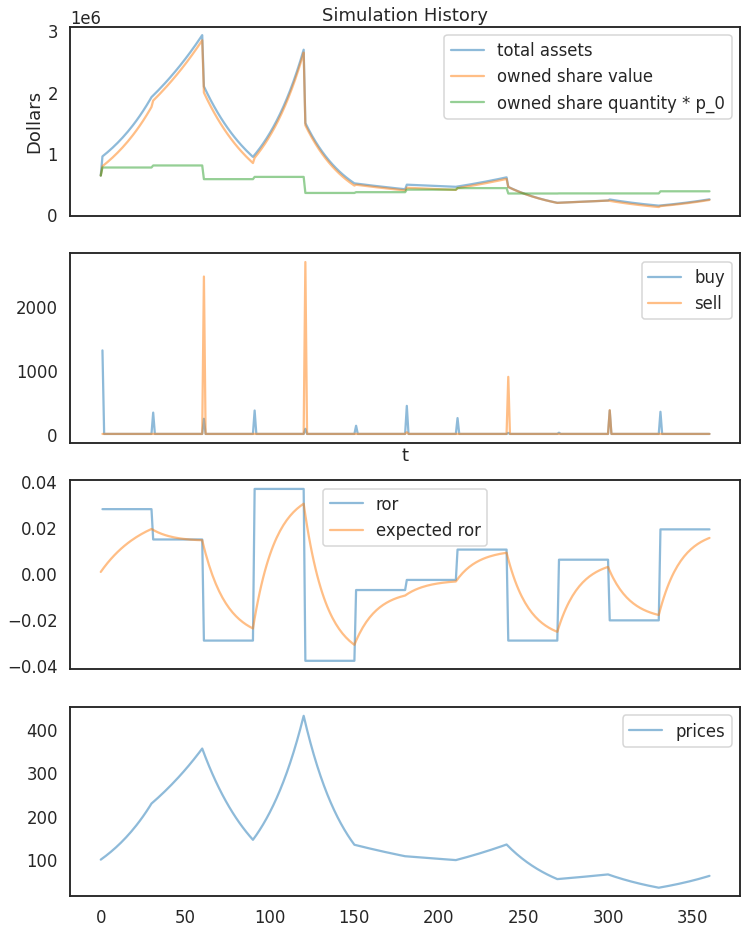

In [17]:
fig, ax = plt.subplots(
    4, 1,
    sharex='col',
    #sharey='col',
    figsize=(12,16),
)

ax[0].plot(data['total_assets'], alpha=0.5, label='total assets')
ax[0].plot([p * o for (p,o) in zip(data['prices'], data['owned'])], alpha=0.5, label='owned share value')
ax[0].plot([100 * o for (p,o) in zip(data['prices'], data['owned'])], alpha=0.5, label='owned share quantity * p_0')
ax[0].legend()

ax[1].plot(data['buy'], alpha=0.5, label='buy')
ax[1].plot(data['sell'], alpha=0.5, label='sell')
ax[1].legend()

ax[2].plot(data['ror'], alpha=0.5, label='ror')
ax[2].plot(data['expected_ror'], alpha=0.5, label='expected ror')
ax[2].legend()

ax[3].plot(data['prices'], alpha=0.5, label='prices')
ax[3].legend()
    
ax[0].set_title("Simulation History")
ax[0].set_ylabel("Dollars")
ax[1].set_xlabel("t")
        
plt.show()

In [18]:
data.corr()

,t,prices,buy,sell,owned,total_assets,ror,expected_ror,expected_std
t,1.000000,-0.742695,-0.079359,-0.047970,-0.821735,-0.810136,-0.179866,-0.301329,-0.164260
prices,-0.742695,1.000000,-0.023455,0.170611,0.600855,0.908057,0.069313,0.484371,0.352458
buy,-0.079359,-0.023455,1.000000,0.149677,0.083701,0.005119,0.068998,0.002189,-0.042607
sell,-0.047970,0.170611,0.149677,1.000000,-0.022533,0.081230,-0.121660,0.113783,0.026730
owned,-0.821735,0.600855,0.083701,-0.022533,1.000000,0.855843,0.536174,0.595482,-0.122973
total_assets,-0.810136,0.908057,0.005119,0.081230,0.855843,1.000000,0.307417,0.597103,0.096945
ror,-0.179866,0.069313,0.068998,-0.121660,0.536174,0.307417,1.000000,0.694485,-0.208072
expected_ror,-0.301329,0.484371,0.002189,0.113783,0.595482,0.597103,0.694485,1.000000,-0.153885
expected_std,-0.164260,0.352458,-0.042607,0.026730,-0.122973,0.096945,-0.208072,-0.153885,1.000000


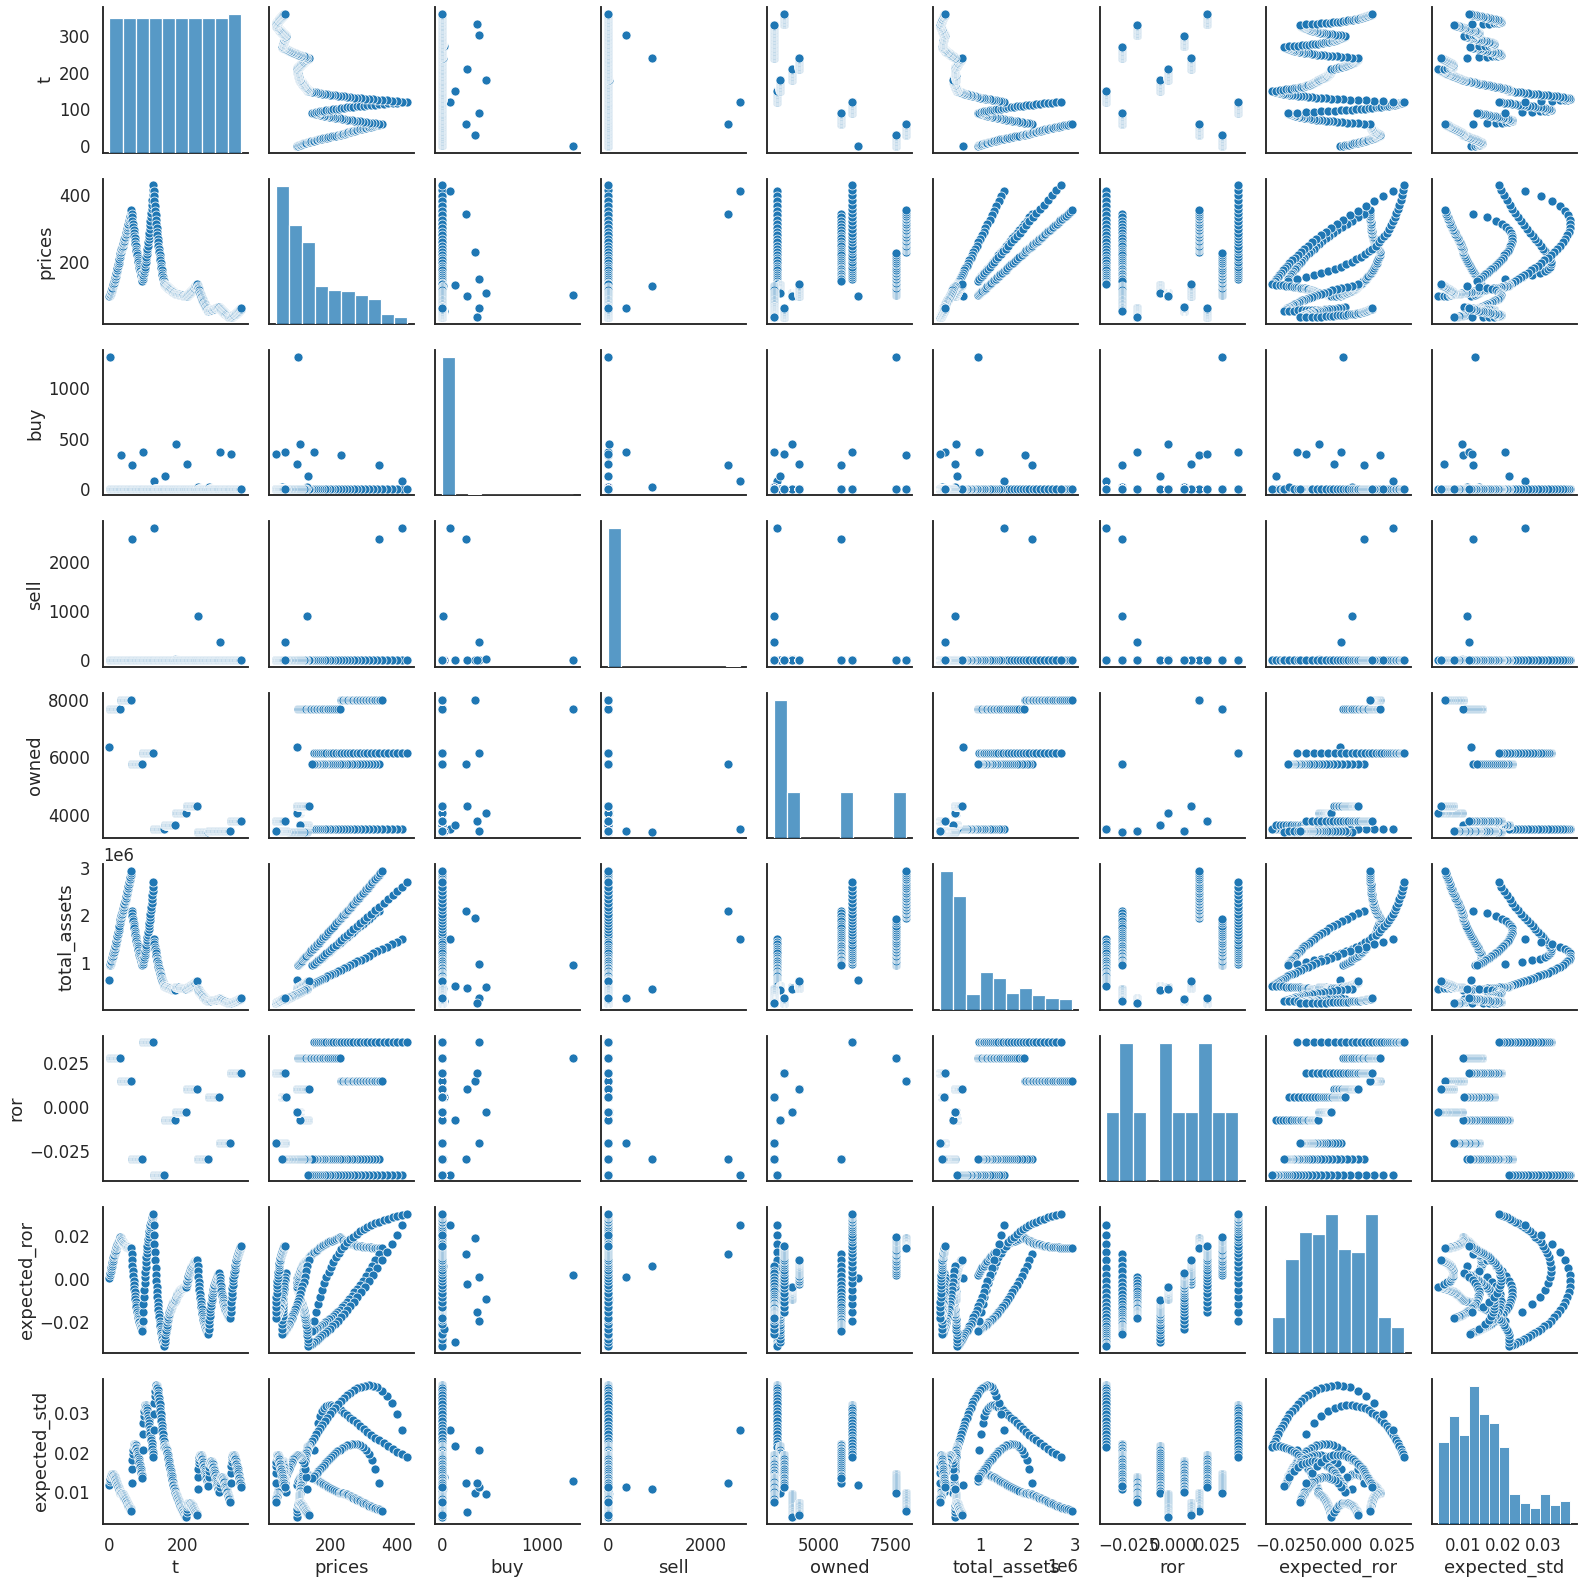

In [19]:
import seaborn as sns

sns.pairplot(data)